In [28]:
import pandas as pd
import json
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
import holidays

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from flaml import AutoML

## Step 1: Import Data

In [38]:
# Load data
df = pd.read_csv('allgenre_combined_df.csv') 
df.head(3)

/Users/Sherry/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
0,2024-09-18,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,9,2
1,2024-09-14,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,9,5
2,2024-09-13,Bruce Springsteen & The E Street Band,Bruce Springsteen & The E Street Band,"['heartland rock', 'mellow gold', 'permanent w...",6567386.0,79.0,Bruce Springsteen & The E Street Band,UCcu7ANuD9J7hnTQCREqIc4Q,Bruce Springsteen,Bruce Springsteen's official YouTube channel.,...,Pop / Rock,39646.0,6556587.0,39646.0,100%,49.5,299.5,165.38,9,4


In [53]:
# Filter Data: The Year must be 2020 or later, The Headliner column must not contain double quotes (double quotes usually means it's festival), The Genre must not be "Family Entertainment" (that's sports)
data = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
data = data.dropna()
data['Event Date'] = pd.to_datetime(data['Event Date'], errors='coerce')
# Reset index after dropping rows
data = data.reset_index(drop=True)

In [54]:
data

,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
0,2024-09-18,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,9,2
1,2024-09-14,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,9,5
2,2024-09-13,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,14995.0,1402969.0,14995.0,100%,39.5,225.0,93.56,9,4
3,2024-09-11,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,19303.0,1512310.0,19303.0,100%,39.5,159.5,78.35,9,2
4,2024-09-10,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,10945.0,801952.0,10945.0,100%,39.5,159.5,73.27,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,2020-01-16,Ider,Ider,[],5.0,0.0,Ider,UCv8KgX89OA0yyPVAgoxx5lw,IDER,'Late To The World' OUT NOW! \n\nThe title tra...,...,Pop / Rock,227.0,3282.0,250.0,90%,15.0,100.0,14.46,1,3
3357,2020-01-16,Green Jelly,Green Jelly,"['comic metal', 'funk metal']",60041.0,35.0,Green Jelly,UCW8soHbDw-sZ8X2Cjb-2VcA,Green Jellÿ,Official Channel of Green Jello / Green Jelly\...,...,Pop / Rock,117.0,1260.0,200.0,58%,10.0,12.0,10.77,1,3
3358,2020-01-15,Grace Potter,Grace Potter,[],126207.0,55.0,Grace Potter,UChZPBtiR55itE778bGV3PlQ,Grace Potter,New album “Mother Road” out now: https://found...,...,Pop / Rock,852.0,36679.0,1868.0,45%,38.5,48.5,43.05,1,2
3359,2020-01-15,Caroline Polachek,Caroline Polachek,"['art pop', 'escape room', 'indie pop', 'indie...",542299.0,62.0,Caroline Polachek,UC_YiGpMGuBb1PbjqPQMf9MQ,Caroline Polachek,The official YouTube channel of Caroline Polachek,...,Pop / Rock,500.0,9250.0,500.0,100%,20.0,100.0,18.50,1,2


In [52]:
# check the avaiablity of each features
# Calculate the percentage of non-null values for each column
percentages = {}
data_types = {}
for column in data.columns:
    percentage = (data[column].count() / len(data)) * 100
    percentages[column] = percentage
    # Get the data type of each column
    data_types[column] = data[column].dtype

# Convert the dictionaries to a DataFrame
result_df = pd.DataFrame({
    'Percentage': percentages,
    'Data Type': data_types
})

# Set the index name
result_df.index.name = 'Column'

print(result_df)

                                 Percentage       Data Type
Column                                                     
Event Date                       100.000000  datetime64[ns]
Headliner                        100.000000          object
sp artist_name                    13.170872          object
sp artist_genre                   13.170872          object
sp followers                      13.170872         float64
sp popularity                     13.170872         float64
yt name                           13.134482          object
yt Channel ID                     13.134482          object
yt Title                          13.134482          object
yt Description                    10.493029          object
yt Published At                   13.134482          object
yt View Count                     13.134482         float64
yt Subscriber Count               13.134482         float64
yt Video Count                    13.134482         float64
Total population                  13.173

##  Step 2: Data processing

In [42]:
# Convert all object-type columns to string
data = data.astype({col: 'string' for col in data.select_dtypes(include='object').columns})

    

In [43]:
# Extra Features: Location
# create a Location column using 'City', 'State','Country'
# not using state here since lots of country do not have state
data['Location'] = data['City'] + '_' + data['Country']

# Extra Features: seasonality
# extract month from Event Date to represent seasonality
data['Event Date'] = pd.to_datetime(data['Event Date'], format='%m/%d/%Y')
data['Month'] = data['Event Date'].dt.month


# Extra feature: Holiday or Not
def is_holiday(date):
    us_holidays = holidays.US()
    return date in us_holidays
data['is_holiday'] = data['Event Date'].apply(is_holiday)

In [44]:
# Reset index after dropping rows
data = data.reset_index(drop=True)

In [49]:
# check distribution
distribution_summary = data['Avg. Gross USD'].describe()
print("Distribution Summary:",distribution_summary)
distribution_summary = data['Ticket Price Avg. USD'].describe()
print("Distribution Summary:",distribution_summary)

Distribution Summary: count    3.892000e+03
mean     2.779095e+05
std      6.041879e+05
min      1.130000e+02
25%      9.897750e+03
50%      4.339650e+04
75%      2.628754e+05
max      1.044296e+07
Name: Avg. Gross USD, dtype: float64
Distribution Summary: count    3892.000000
mean       46.817664
std        33.637546
min         1.000000
25%        23.627500
50%        36.920000
75%        60.017500
max       297.130000
Name: Ticket Price Avg. USD, dtype: float64


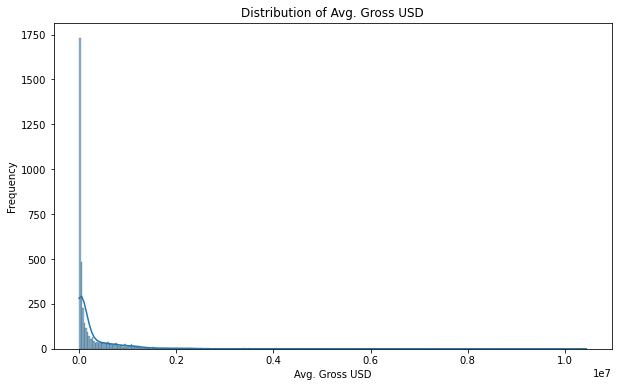

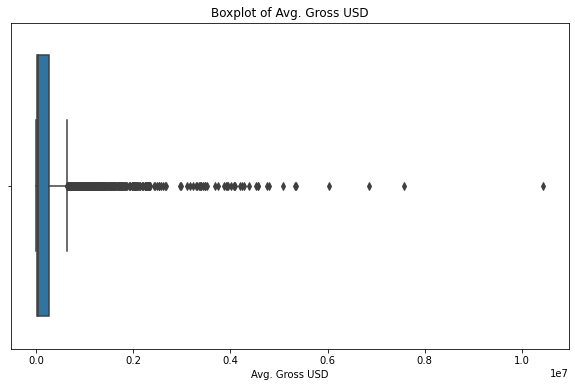

In [13]:
# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Avg. Gross USD', kde=True)
plt.title('Distribution of Avg. Gross USD')
plt.xlabel('Avg. Gross USD')
plt.ylabel('Frequency')
plt.show()

# Identify outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Avg. Gross USD')
plt.title('Boxplot of Avg. Gross USD')
plt.xlabel('Avg. Gross USD')
plt.show()

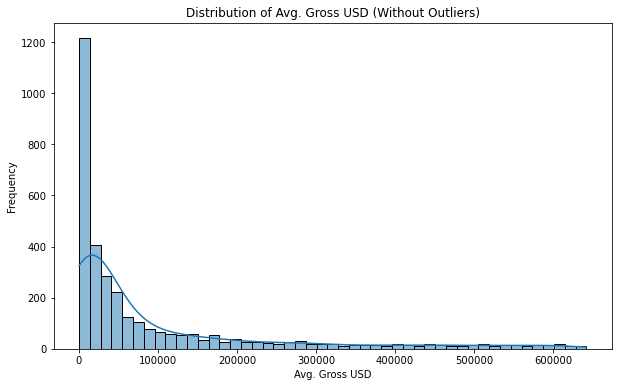

In [14]:
# Define the lower and upper bounds
Q1 = data['Avg. Gross USD'].quantile(0.25)
Q3 = data['Avg. Gross USD'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
data = data[(data['Avg. Gross USD'] >= lower_bound) & (data['Avg. Gross USD'] <= upper_bound)]

# Plot the distribution without outliers
plt.figure(figsize=(10, 6))
# sns.histplot(data=data_no_outliers, x='Avg. Gross USD', kde=True)
sns.histplot(data=data, x='Avg. Gross USD', kde=True)
plt.title('Distribution of Avg. Gross USD (Without Outliers)')
plt.xlabel('Avg. Gross USD')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Convert categorical 'day_of_week' variable using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)

In [17]:
# output the data into a csv file
data_encoded.to_csv('cleaned_data_allgenre.csv', index=False)

# Step 3: Model Training

In [18]:
# Load data
data = pd.read_csv('cleaned_data_allgenre.csv') 
data.head(3)

,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Ticket Price Avg. USD,Month,Location,is_holiday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2024-09-10,Meghan Trainor,Meghan Trainor,"['hip pop', 'pop']",15386185.0,80.0,Meghan Trainor,UCkXgEcpoTE4tHsebYBouWpA,Meghan Trainor,Meghan Trainor first made history in 2014 with...,...,46.40,9,Franklin_United States,False,1,0,0,0,0,0
1,2024-08-30,Big Time Rush,Big Time Rush,"['boy band', 'pop', 'post-teen pop']",2644381.0,65.0,Big Time Rush,UCrX2OMYTBcodUKQMBLfMrJQ,Big Time Rush,Official YouTube channel of Big Time Rush,...,73.93,8,Costa Mesa_United States,False,0,0,0,1,0,0
2,2024-08-30,O.A.R.,O.A.R.,"['neo mellow', 'pop rock']",404435.0,54.0,O.A.R.,UCG4iZbtQvjI4gSJdIunjrKQ,O.A.R. (Of A Revolution...),Widely accepted as one the most successful ind...,...,46.46,8,Newport_United States,False,0,0,0,1,0,0


In [19]:
# Split data into features (X) and target variable (y)
X = data.drop('Avg. Gross USD', axis=1) 
y = data['Avg. Gross USD']

# drop column can't be used for model
X=data.drop(['Avg. Tickets Sold', 'Ticket Price Avg. USD'], axis=1) 

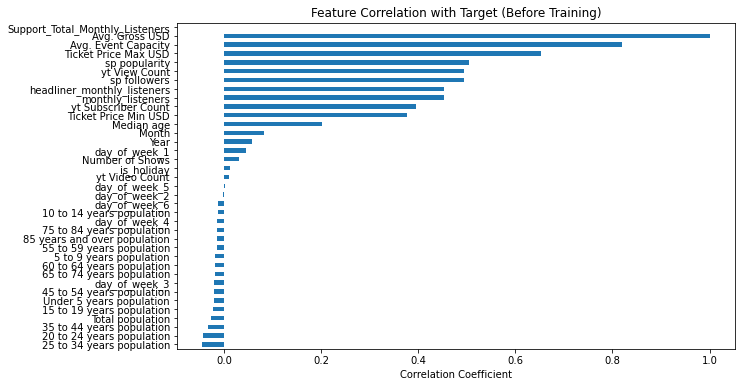

In [20]:
# Plotting Feature Correlation (Before Model Training)
# Calculate correlations with the target variable
correlations = X.corrwith(y)

# Plot the correlation with the target
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh')
plt.title('Feature Correlation with Target (Before Training)')
plt.xlabel('Correlation Coefficient')
plt.show()

In [21]:
selected_columns=['Avg. Event Capacity'
                  # ,'yt Subscriber Count'
                  # ,'yt View Count'
                  ,'sp followers'
                  ,'sp popularity'
                  , 'Ticket Price Min USD'
                  , 'Ticket Price Max USD'
                  ,'Median age'
                ,'Number of Shows'
                  #,'is_holiday'
                  , 'Month'
                 ]
X=X[selected_columns]

In [22]:
# Convert the month column to a categorical type
data['Month'] = data['Month'].astype('category').cat.codes  # converts categories to integer codes

In [23]:
# Initialize the Linear Regression model
model = LinearRegression()

# Define scoring functions for RMSE and R^2
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE
r2_scorer = make_scorer(r2_score)  # R^2

# Perform cross-validation on the entire dataset for RMSE
cv_rmse_scores = cross_val_score(model, X, y, cv=10, scoring=rmse_scorer)
average_rmse = np.mean(cv_rmse_scores)

# Perform cross-validation on the entire dataset for R^2
cv_r2_scores = cross_val_score(model, X, y, cv=10, scoring=r2_scorer)
average_r2 = np.mean(cv_r2_scores)

# Output cross-validation results
print("Cross-Validation RMSE for each fold:", cv_rmse_scores)
print("Average Cross-Validation RMSE:", average_rmse)
print("Cross-Validation R^2 for each fold:", cv_r2_scores)
print("Average Cross-Validation R^2:", average_r2)

# Train the model on the full dataset
model.fit(X, y)

# Predict on the full dataset
y_pred = model.predict(X)

# Calculate RMSE and R^2 on the full dataset
full_rmse = mean_squared_error(y, y_pred, squared=False)
full_r2 = r2_score(y, y_pred)

print("Full Dataset RMSE:", full_rmse)
print("Full Dataset R^2:", full_r2)

Cross-Validation RMSE for each fold: [ 85417.52924184  57892.95363901  63027.7810173  109871.75948388
  64310.4467027   46642.98052326  61586.26347152  72013.63224289
  57031.38040678 103738.49516125]
Average Cross-Validation RMSE: 72153.32218904396
Cross-Validation R^2 for each fold: [0.71746072 0.76799124 0.85306079 0.66119293 0.73540161 0.77728488
 0.75384531 0.78256035 0.74509699 0.50501435]
Average Cross-Validation R^2: 0.7298909177536742
Full Dataset RMSE: 71249.53162832525
Full Dataset R^2: 0.7619080340679592


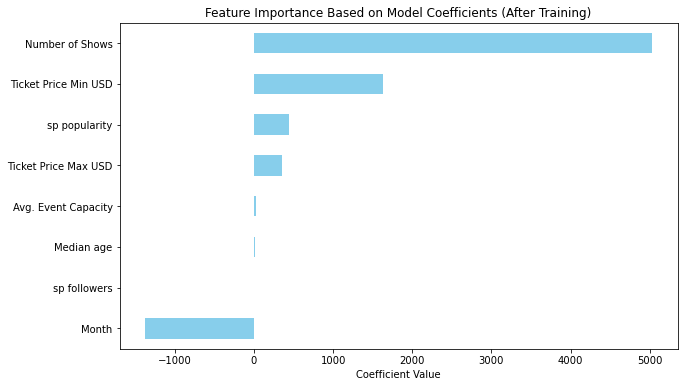

In [24]:
# Plot feature importance

# Get the coefficients
coefficients = pd.Series(model.coef_, index=X.columns)

# Plot feature importance based on model coefficients
plt.figure(figsize=(10, 6))
coefficients.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importance Based on Model Coefficients (After Training)')
plt.xlabel('Coefficient Value')
plt.show()

Ridge Cross-Validation RMSE: [ 85416.52948064  57893.12054158  63028.12436939 109870.9661877
  64310.49163493  46641.30835408  61585.45915629  72013.873099
  57031.7562457  103738.60347219]
Ridge Average RMSE: 72153.02325415003
Ridge Cross-Validation R^2: [0.71746733 0.7679899  0.85305919 0.66119782 0.73540124 0.77730085
 0.75385174 0.7825589  0.74509363 0.50501331]
Ridge Average R^2: 0.7298933925789264
Ridge Full Dataset RMSE: 71249.53197603513
Ridge Full Dataset R^2: 0.7619080317441003


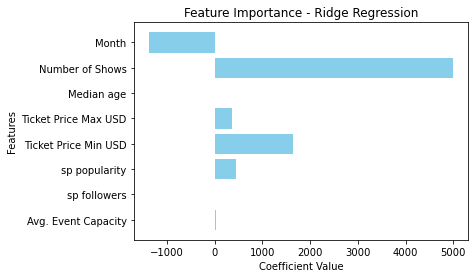

In [25]:
# Ridge Regression
from sklearn.linear_model import Ridge
# Initialize Ridge model
ridge_model = Ridge(alpha=1)  # You can adjust alpha as needed

# Define scoring functions for RMSE and R^2
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE
r2_scorer = make_scorer(r2_score)  # R^2

# Perform cross-validation for Ridge model
cv_rmse_ridge = cross_val_score(ridge_model, X, y, cv=10, scoring=rmse_scorer)
cv_r2_ridge = cross_val_score(ridge_model, X, y, cv=10, scoring=r2_scorer)

# Train the Ridge model on the full dataset
ridge_model.fit(X, y)
ridge_coef = ridge_model.coef_

# Output cross-validation results for Ridge
print("Ridge Cross-Validation RMSE:", cv_rmse_ridge)
print("Ridge Average RMSE:", np.mean(cv_rmse_ridge))
print("Ridge Cross-Validation R^2:", cv_r2_ridge)
print("Ridge Average R^2:", np.mean(cv_r2_ridge))

# Calculate RMSE and R^2 on the full dataset for Ridge
ridge_full_rmse = mean_squared_error(y, ridge_model.predict(X), squared=False)
ridge_full_r2 = r2_score(y, ridge_model.predict(X))
print("Ridge Full Dataset RMSE:", ridge_full_rmse)
print("Ridge Full Dataset R^2:", ridge_full_r2)

# Plot feature importance for Ridge
feature_names = X.columns
plt.figure(figsize=(6, 4))
plt.barh(feature_names, ridge_coef, color='skyblue')
plt.title('Feature Importance - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

In [26]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np

# Create DMatrix with enable_categorical
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# Define parameters
params = {
    'objective': 'reg:squarederror',  # for regression
    'max_depth': 3,
    'eta': 0.1,
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

In [27]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np

# Assuming X and y are already defined
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'tree_method': ['hist']
}

# Use GridSearchCV to perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Use RMSE for scoring
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

# Perform cross-validation to calculate RMSE and R^2 scores on the best model
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE scorer
rmse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=rmse_scorer)
r2_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

# Print Cross-Validation Scores
print("XGBoost Cross-Validation RMSE:", rmse_scores)
print("XGBoost Average RMSE:", np.mean(rmse_scores))
print("XGBoost Cross-Validation R^2:", r2_scores)
print("XGBoost Average R^2:", np.mean(r2_scores))

# Train on the full training set and evaluate on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate RMSE and R^2 for the test set
rmse_full = mean_squared_error(y_test, y_pred, squared=False)
r2_full = r2_score(y_test, y_pred)

print("XGBoost Full Dataset Testset RMSE:", rmse_full)
print("XGBoost Full Dataset Testset R^2:", r2_full)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'tree_method': 'hist'}
XGBoost Cross-Validation RMSE: [49286.55937651 46681.39545082 43865.85904342 50509.14855872
 39577.63414518]
XGBoost Average RMSE: 45984.11931493059
XGBoost Cross-Validation R^2: [0.88173514 0.88844527 0.9072032  0.87689833 0.93026957]
XGBoost Average R^2: 0.8969103007455912
XGBoost Full Dataset Testset RMSE: 43631.20871420655
XGBoost Full Dataset Testset R^2: 0.9182335378110953
